In [1]:
%pylab inline
import pandas as pd
import numpy as np
import os
import sklearn as sk
from sklearn.cluster import AffinityPropagation
from sklearn import datasets
from sklearn import metrics
from multiprocessing import Pool
import pickle

Populating the interactive namespace from numpy and matplotlib


### Clustering before compressed neighborhoods

In [2]:
mr = pd.read_csv('mr.csv', index_col=0)

Creating feature vector matrix. Each vector represents a patient and each feature is 1 if gene is mutated, 0 otherwise.

In [3]:
mr = mr[np.isfinite(mr['Seq_Gene_Id'])]

In [4]:
mr.Seq_Gene_Id.apply(np.isnan).value_counts()

False    30040
dtype: int64

In [5]:
# for each patient barcode, have an array of length number of genes, populated with 0/1 for mutations
matrix = [[0 for gene in mr.Seq_Gene_Id.unique()] for patient in mr.Patient_Barcode.unique()]
for p_index, patient in enumerate(mr.Patient_Barcode.unique()):
    # get list of mutated genes?
    mutated_genes = mr[mr['Patient_Barcode'] == patient].Seq_Gene_Id
    for g_index, gene in enumerate(mr.Seq_Gene_Id.unique()):
        if gene in mutated_genes:
            matrix[p_index][g_index] = 1

In [6]:
df_matrix = pd.DataFrame(matrix)

Running affinity propogation on the vector matrix to get clusters.

In [7]:
af = AffinityPropagation().fit(df_matrix)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

Plot cluster by gene mutations. Must create new column with basic classification.

In [9]:
# create series with length of all mutations; mapping cluster assignment to patient
basic_class = []
for i, patient in enumerate(mr.Patient_Number):
    try:
        basic_class.append(labels[int(patient)])
    except:
        print i, patient
mr['basic_classification'] = pd.Series(basic_class)

In [10]:
mr.head()

,Hugo_Symbol,Entrez_Gene_Id,Seq_Gene_Id,Patient_Number,Patient_Barcode,Variant_Classification,Both_Alleles,basic_classification
0,A1CF,29974,0,0,TCGA-ET-A39P,Silent,True,0
1,A2M,2,1,1,TCGA-BJ-A0ZB,Missense_Mutation,True,1
2,A2ML1,144568,2,2,TCGA-ET-A40S,Frame_Shift_Del,True,2
3,A2ML1,144568,2,3,TCGA-E8-A413,Silent,True,3
4,A2ML1,144568,2,4,TCGA-DJ-A4UT,Missense_Mutation,True,4


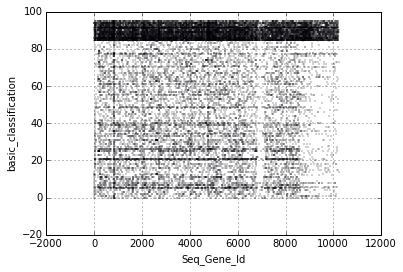

In [11]:
mr.plot(kind='scatter', y='basic_classification', x='Seq_Gene_Id', s=0.05)